# ML lab 05 - Resampling methods

## Methods for evaluating and/or comparing/selecting models/hyperparameters


Properly assessing the quality of **future** predictions of a trained model (i.e. its **predictive error**, or **generalization error**) is undoubtedly critical in order to be able to produce such a model. If we had access to more data, then all we would need to do is obtain them and assess the trained models with these new data examples. However, the typical scenario is to work with a finite sample and it is very costly or directly impossible to obtain new data. In this second scenario, we resort to **resampling methods** to make the most of our training data in order to:
1. assess predictive performance, and 
2. select hyper-parameters and select most-promising models.

This script includes examples of most common resampling mathods, from more simple to more sophisticated. Resampling methods are methods that partition the available data in various ways, in order to estimate **predictive error** on the basis of **validation** metrics.

***

## Example 1: estimating predictive error with least-squares linear regression (no hyper-parameters)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

from numpy.random import uniform, normal

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 2)
np.set_printoptions(precision=2)

plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

np.random.seed(123) # for reproducibility

We use a simple linear data generating mechanism with Gaussian noise

In [2]:
def feval(x):
    return -0.3 + 1.2 * x

def fgen(N, sigma):
    a = 0   # left x limit
    b = 1   # right x limit

    x = np.sort(uniform(a, b, N))
    t = feval(x) + normal(loc=0, scale=sigma, size=N)  
    return x,t

We start generating a sample of 10 examples generating the data assuming that has gaussian noise $N(0,1)$; this is going to be our training set.

In [3]:
N = 10
sigma = 1

x,t = fgen(N, sigma)
training_set = pd.DataFrame({'input':x,'target':t})

X = training_set.input.to_numpy().reshape(-1, 1)
y = training_set.target

We visualize the generated data: red dots are the training datas, green line is true underlying data-generating line, blue line is least squares fitted line.

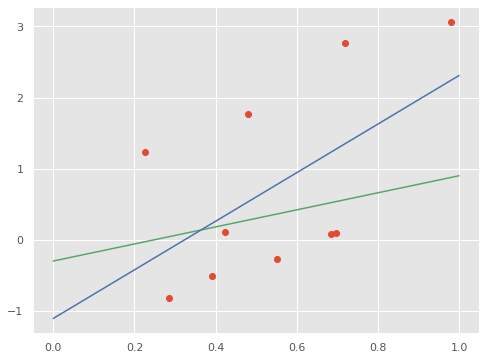

In [4]:
ols = LinearRegression()
ols.fit(X, y)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(training_set.input, training_set.target, 'o')
ax.plot(np.linspace(0, 1,num=2), feval(np.linspace(0, 1,num=2)), 'g-')
ax.plot(np.linspace(0, 1,num=2), [ols.intercept_, ols.intercept_ + ols.coef_], 'b-');

Now we generate a test set using the same mechanism. The test set will be **very** large because we want to be able to assess the **generalization error** of our trained linear model.

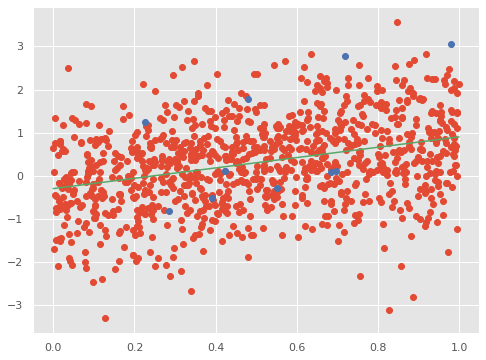

In [5]:
N_test = 1000
x,t = fgen(N_test, sigma)
test_set = pd.DataFrame({'input':x,'target':t})

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_set.input, test_set.target, 'o')
ax.plot(training_set.input, training_set.target, 'bo')
ax.plot(np.linspace(0, 1,num=2), feval(np.linspace(0, 1,num=2)), 'g-');

Now we assess predictive error (we'll use MSE) using: 
1. training error 
2. train/val single split
3. Monte-Carlo cross-validation (10x) 
4. k-fold cross-validation
5. 10xk iterated cross-validation
6. loocv

In [6]:
# 1. Training error
ols = LinearRegression()
ols.fit(X, y)
training_error = mean_squared_error(y, ols.predict(X))

# 2. Single Train/Validation error
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
ols.fit(X_train, y_train)
single_val_error = mean_squared_error(y_val, ols.predict(X_val))

# 3. Monte carlo cross-val (with k=1 up to 'repeats' repetitions)
repeats = 10
scores = []
for i in range(repeats):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    ols.fit(X_train, y_train)
    scores.append(mean_squared_error(y_val, ols.predict(X_val)))
mc_cross_val = np.cumsum(scores) / np.arange(1,len(scores)+1)

# 4. k-fold cross-validation
all_k = range(2, N+1)
cross_val = np.zeros(N+1)
for k in all_k:
    scores = -cross_val_score(ols, X, y, cv=k, scoring='neg_mean_squared_error')
    cross_val[k] = scores.mean()

# 5. 10xk cross-val
repeated_cross_val = np.zeros(N+1)
for k in all_k:
    rkf = RepeatedKFold(n_splits=k, n_repeats=repeats)
    this_k = []
    for train_index, val_index in rkf.split(X):
    
        x_train_fold = X[train_index]
        y_train_fold = y[train_index]
        x_val_fold = X[val_index,:]
        y_val_fold = y[val_index]
            
        ols.fit(x_train_fold, y_train_fold)
        this_k.append(mean_squared_error(y_val_fold, ols.predict(x_val_fold)))
        
    repeated_cross_val[k] = np.mean(this_k)

# 6. LOOCV
loocv_error = cross_val[N]

# 7. True error (on large test set)
X_test = test_set.input.to_numpy().reshape(-1, 1)
y_test = test_set.target

ols.fit(X, y)
test_error = mean_squared_error(y_test, ols.predict(X_test))

# print it
print(f'training: {training_error:.2f}');
print(f'single train/val: {single_val_error:.2f}')
print(f'MC train/val: {mc_cross_val}; average of all runs is {mc_cross_val.mean()}')
print(f'k-fold cross-val: {cross_val[2:]}')
print(f'10xk cross-val: {repeated_cross_val[2:]}')
print(f'loocv: {loocv_error:.2f}')
print(f'test: {test_error:.2f}')
print(f'irreducible error (sigma^2): {sigma**2:.2f}')

training: 1.16
single train/val: 2.78
MC train/val: [1.87 1.52 2.12 1.97 2.45 2.6  2.44 2.64 2.71 2.59]; average of all runs is 2.2900369973511214
k-fold cross-val: [3.77 2.67 3.3  3.04 2.11 1.95 1.95 1.77 1.95]
10xk cross-val: [1.77 2.35 2.2  2.   2.08 1.91 1.91 1.97 1.95]
loocv: 1.95
test: 1.44
irreducible error (sigma^2): 1.00


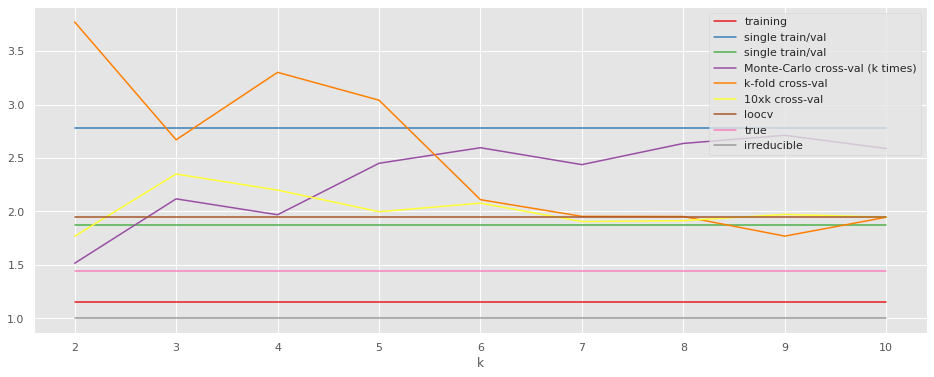

In [7]:
# put it all in a dataframe for easy plotting
from matplotlib import cm

data = [None] * len(all_k)
for i,k in enumerate(all_k):
    data[i] = [k, training_error, single_val_error, mc_cross_val[0], mc_cross_val[k-1], 
               cross_val[k], repeated_cross_val[k], loocv_error, test_error, sigma**2]

df = pd.DataFrame(data, 
                  columns=['k', 'training', 'single train/val', 'single train/val', 'Monte-Carlo cross-val (k times)', 
                           'k-fold cross-val', '10xk cross-val', 'loocv', 'true', 'irreducible'])
df.plot(x='k', figsize=(16,6), xticks=all_k, colormap=cm.get_cmap('Set1'));

***

## Example 2: model selection with single train/val split between ols and ridge

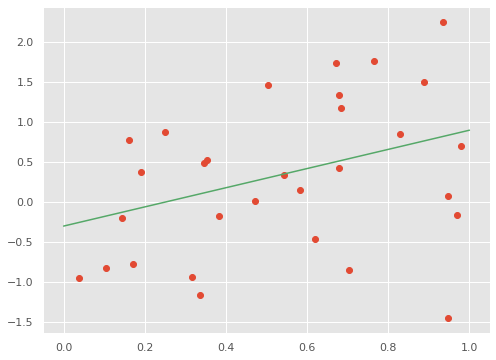

In [8]:
# first generate dataset (we use same mechanism as above)
N = 30
sigma = 1

X,y = fgen(N, sigma)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X, y, 'o')
ax.plot(np.linspace(0, 1,num=2), feval(np.linspace(0, 1,num=2)), 'g-');

### (1) split available data into training + test set

notice that we call `X_learn` the training partition to avoid clash with train later on on train/val split

In [9]:
X_learn, X_test, y_learn, y_test = train_test_split(X.reshape(-1, 1), y, test_size=0.33)

In [10]:
X_learn.size, y_learn.size, X_test.size, y_test.size

(20, 20, 10, 10)

### (2) use train/val split as resampling method for tuning $\lambda$ and selecting model

Notice that in this step **we do not look into the test set at all**

In [11]:
# split "learn" into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_learn, y_learn, test_size=0.5)

# train ols model and estimate performance on validation set
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_val_score = mean_squared_error(y_val, ols.predict(X_val))

# train ridge model with different lambdas and estimate performance on validation set
all_lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5, 1, 5, 10, 50, 100]
ridge_val_score = np.zeros(len(all_lambdas))
for i, l in enumerate(all_lambdas):
    lr = Ridge(alpha=l)
    lr.fit(X_train, y_train)
    ridge_val_score[i] = mean_squared_error(y_val, lr.predict(X_val))

# show validation scores
print(f'OLS validation score: {ols_val_score}')
print(f'Ridge validation scores:')
for i, l in enumerate(all_lambdas):
    print(f'\t lambda={l}; validation_score: {ridge_val_score[i]:.2f}')
print()
    
# select winner..
best = np.argmin(ridge_val_score)
best_lambda = all_lambdas[best]
print(f'Best lambda in ridge is {best_lambda} with score {ridge_val_score[best]:.2f}')
print(f'OLS has score {ols_val_score:.2f}')
if ridge_val_score[best] < ols_val_score:
    print(f'So, Ridge with lambda {best_lambda} wins.')
    winner = Ridge(alpha=best_lambda)
else:
    print(f'So, OLS wins.')
    winner = LinearRegression()
    

OLS validation score: 1.2567817560155325
Ridge validation scores:
	 lambda=1e-10; validation_score: 1.26
	 lambda=1e-05; validation_score: 1.26
	 lambda=0.0001; validation_score: 1.26
	 lambda=0.001; validation_score: 1.26
	 lambda=0.01; validation_score: 1.26
	 lambda=0.1; validation_score: 1.26
	 lambda=0.5; validation_score: 1.27
	 lambda=1; validation_score: 1.27
	 lambda=5; validation_score: 1.28
	 lambda=10; validation_score: 1.29
	 lambda=50; validation_score: 1.29
	 lambda=100; validation_score: 1.29

Best lambda in ridge is 1e-10 with score 1.26
OLS has score 1.26
So, OLS wins.


### (3) build winning model on whole training set

In [12]:
winner.fit(X_learn, y_learn)

LinearRegression()

### (4) estimate predictive error of trained final model on test set

In [13]:
y_pred = winner.predict(X_test)
test_score = mean_squared_error(y_test, y_pred)
print(f'The TEST mse of final model is: {test_score:.2f}')

The TEST mse of final model is: 0.71


***

## Example 3: model selection with 3-fold cross-validation between ols and ridge

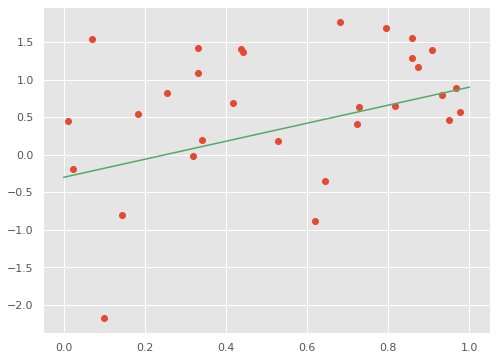

In [14]:
# first generate dataset (we use same mechanism as above)
N = 30
sigma = 1

X,y = fgen(N, sigma)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X, y, 'o')
ax.plot(np.linspace(0, 1,num=2), feval(np.linspace(0, 1,num=2)), 'g-');

### (1) split available data into training + test set

notice that we call `X_learn` the training partition to avoid clash with train later on on train/val split

In [15]:
X_learn, X_test, y_learn, y_test = train_test_split(X.reshape(-1, 1), y, test_size=0.33)

In [16]:
X_learn.size, y_learn.size, X_test.size, y_test.size

(20, 20, 10, 10)

### (2) use 3-fold cross-val as resampling method for tuning $\lambda$ and selecting model

Notice that in this step **we do not look into the test set at all**

In [17]:
# do cross-val by hand because OLS does not have 'CV' option..
kf = KFold(n_splits=3, shuffle=True)

# these accumulate scores for each fold, at the end we average
ols_val_score = []
ridge_val_score = [ [] for _ in all_lambdas ]

In [18]:
for train_index, val_index in kf.split(X_learn):
    X_train = X_learn[train_index]
    X_val = X_learn[val_index]
    y_train = y_learn[train_index]
    y_val = y_learn[val_index]

    # train ols model and estimate performance on validation set
    ols = LinearRegression()
    ols.fit(X_train, y_train)
    ols_val_score.append(mean_squared_error(y_val, ols.predict(X_val)))

    # train ridge model with different lambdas and estimate performance on validation set
    all_lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5, 1, 5, 10, 50, 100]
    for i, l in enumerate(all_lambdas):
        lr = Ridge(alpha=l)
        lr.fit(X_train, y_train)
        ridge_val_score[i].append(mean_squared_error(y_val, lr.predict(X_val)))

# average accross all folds..
ols_val_score = np.mean(ols_val_score)
ridge_val_score = [np.mean(x) for x in ridge_val_score]

# select winner..
best = np.argmin(ridge_val_score)
best_lambda = all_lambdas[best]
print(f'Best lambda in ridge is {best_lambda} with score {ridge_val_score[best]:.2f}')
print(f'OLS has score {ols_val_score:.2f}')
if ridge_val_score[best] < ols_val_score:
    print(f'So, Ridge with lambda {best_lambda} wins.')
    winner = Ridge(alpha=best_lambda)
else:
    print(f'So, OLS wins.')
    winner = LinearRegression()

Best lambda in ridge is 100 with score 0.55
OLS has score 0.68
So, Ridge with lambda 100 wins.


### (3) build winning model on whole training set

In [19]:
winner.fit(X_learn, y_learn)

Ridge(alpha=100)

### (4) estimate predictive error of trained final model on test set

In [20]:
y_pred = winner.predict(X_test)
test_score = mean_squared_error(y_test, y_pred)
print(f'The TEST mse of final model is: {test_score:.2f}')

The TEST mse of final model is: 1.18


***

## Example 4: model selection with LOOCV between ols and ridge

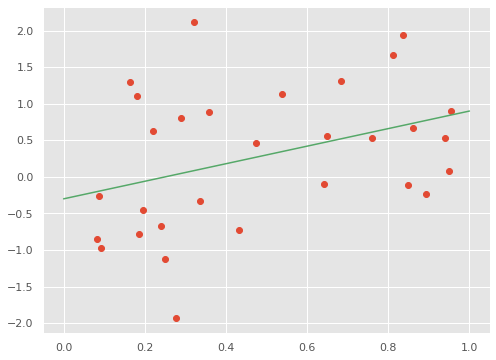

In [21]:
# first generate dataset (we use same mechanism as above)
N = 30
sigma = 1

X,y = fgen(N, sigma)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X, y, 'o')
ax.plot(np.linspace(0, 1,num=2), feval(np.linspace(0, 1,num=2)), 'g-');

### (1) split available data into training + test set

notice that we call `X_learn` the training partition to avoid clash with train later on on train/val split

In [22]:
X_learn, X_test, y_learn, y_test = train_test_split(X.reshape(-1, 1), y, test_size=0.33)

In [23]:
X_learn.size, y_learn.size, X_test.size, y_test.size

(20, 20, 10, 10)

### (2) use LOOCV as resampling method for tuning $\lambda$ and selecting model

Notice that in this step **we do not look into the test set at all**

In [24]:
# we use the power of scikit-learn to make our lives easier using `cross_val_score` which does the cross-val for us

all_lambdas = [1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 50, 100]

lr = LinearRegression()
ols_loocv = np.mean(-cross_val_score(lr, X_learn,y_learn, cv=len(y_learn), scoring='neg_mean_squared_error'))

ridge_loocv = np.zeros(len(all_lambdas))
for i, l in enumerate(all_lambdas):
    r = Ridge(alpha=l)
    ridge_loocv[i] = np.mean(-cross_val_score(r, X_learn, y_learn, cv=len(y_learn), scoring='neg_mean_squared_error'))

# select winner..
best = np.argmin(ridge_loocv)
best_lambda = all_lambdas[best]
print(f'Best lambda in ridge is {best_lambda} with score {ridge_loocv[best]:.2f}')
print(f'OLS has score {ols_loocv:.2f}')
if ridge_loocv[best] < ols_loocv:
    print(f'So, Ridge with lambda {best_lambda} wins.')
    winner = Ridge(alpha=best_lambda)
else:
    print(f'So, OLS wins.')
    winner = LinearRegression()

# build winner model
winner = Ridge(alpha=best_lambda)

Best lambda in ridge is 1 with score 0.93
OLS has score 0.95
So, Ridge with lambda 1 wins.


### (3) build winning model on whole training set

In [25]:
winner.fit(X_learn, y_learn)

Ridge(alpha=1)

### (4) estimate predictive error of trained final model on test set

In [26]:
test_score = mean_squared_error(y_test, winner.predict(X_test))
print(f'The TEST mse of final model is: {test_score:.2f}')

The TEST mse of final model is: 0.91


***

## Exercises for you: implement any (or both) of the missing strategies 

- [ ] 10x3 cross-validation (iterated cross-val)
- [ ] Monte-Carlo train/val splits (10 repetitions)